---
title: "Unsupervised Learning"
format:
    html: 
        code-fold: false
---

## Introduction and Motivation

In the context of this project, unsupervised learning will help identify groups of food items with similar waste characteristics, such as nutritional composition, environmental impact, and economic loss. These clusters can provide actionable insights for targeting interventions, whether through donation strategies, better supply chain management, or more efficient waste disposal practices. Additionally, dimensionality reduction methods like PCA and t-SNE will be used to visualize the multidimensional nature of the food waste data, offering a more intuitive understanding of how different factors correlate and contribute to the problem. By applying unsupervised learning techniques to the Nutrient Waste dataset, this project aims to uncover novel insights that can inform more sustainable food management strategies and policies.

## Model Selection and Code

The goal is to classify food donations, predict dollar surplus from surplus food, and understand primary disposal methods. To achieve this, this section employs several unsupervised learning techniques to uncover patterns and insights from the data, which is structured based on various food-related attributes (e.g., nutritional values, waste amounts, water footprint).

Key Techniques Used for Model Selection:

1.	**Preprocessing**:- Before applying any machine learning techniques, the data undergoes thorough preprocessing to ensure its suitability for analysis:

    •	Handling Missing Values: The project uses imputation strategies to fill missing data, ensuring the integrity of the dataset. The imputer applies strategies median imputation.

    •	Normalization: The numeric columns are normalized using standard or min-max scaling to ensure that all variables contribute equally during clustering and dimensionality reduction. After applying z-score scaling and min-max scaling it was evident that the untransformed data was better for clustering than the normalized data.

2.	**Dimensionality Reduction**:

    •	PCA (Principal Component Analysis): PCA is used for reducing the dimensionality of the dataset while retaining as much variance as possible. This helps in visualizing the data and understanding the primary sources of variability. The explained variance plot provides an insight into the number of components needed to represent the dataset effectively.

    •	t-SNE (t-Distributed Stochastic Neighbor Embedding): t-SNE is applied to visualize the data in two or three dimensions, helping to identify potential clusters or patterns. This technique is particularly useful when dealing with high-dimensional data.

3.	**Clustering**:

    •	K-Means Clustering: The K-Means algorithm is applied to group the data into a predefined number of clusters. This method is chosen due to its simplicity and efficiency. The silhouette score, which measures how well-defined the clusters are, helps in assessing the quality of the clusters. The results are visualized using PCA-reduced data.

    •	DBSCAN (Density-Based Spatial Clustering of Applications with Noise): DBSCAN is chosen for its ability to identify clusters of varying shapes and handle noise effectively. This is especially relevant for datasets where there might be outliers or regions of differing density. Silhouette scores are also computed to assess clustering quality.

    •	Hierarchical Clustering: Hierarchical clustering, using methods like “ward” or “average,” is applied to create a dendrogram. This technique is valuable for understanding the hierarchical relationships between data points and visualizing how clusters are formed at different distance thresholds.

4.	**Evaluation Metrics**:

    •	Silhouette Score: To evaluate the clustering results, the silhouette score is used. This score measures how similar each point is to its own cluster compared to other clusters. A higher silhouette score indicates well-defined and meaningful clusters. This metric is calculated for K-Means, DBSCAN, and hierarchical clustering.

    •	Cluster Visualization: After applying each clustering method, the results are visualized to help understand the distribution of data points and the validity of the identified clusters. Visualizations using PCA or t-SNE reduce the data to two or three dimensions for easier interpretation.

By applying these unsupervised learning techniques, the project aims to uncover hidden patterns in food waste, such as identifying which food categories are most often wasted, understanding the relationships between nutritional composition and waste, and classifying surplus food into clusters that may correlate with its economic value or environmental impact. The combination of dimensionality reduction, clustering, and silhouette-based evaluation ensures that the analysis is both comprehensive and interpretable, making it possible to derive actionable insights for smarter food waste management practices.

In [145]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.metrics import silhouette_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler

class UnsupervisedLearning:
    def __init__(self, data):
        """
        Initialize the UnsupervisedLearning class with the dataset.
        
        Parameters:
            data (pd.DataFrame): Input dataset for analysis.
        """
        self.data = data
        self.pca_result = None
        self.tsne_result = None
        self.clusters = {}
    def preprocess_data(self, impute_strategy='mean', drop_na_threshold=0.5, normalize=True, scaler_type='standard'):
        """
        Preprocess the data to ensure it's suitable for unsupervised learning:
        - Drop columns with excessive missing values.
        - Impute missing values for numeric columns.
        - Convert non-numeric columns to numeric using encoding.
        - Normalize numeric columns if required.

        Parameters:
            impute_strategy (str): Strategy for imputing missing values ('mean', 'median', 'most_frequent').
            drop_na_threshold (float): Threshold for dropping columns with missing values (default: 0.5).
            normalize (bool): Whether to normalize numeric columns (default: True).
            scaler_type (str): Type of scaler to use ('standard' for StandardScaler, 'minmax' for MinMaxScaler).
        """
        # Drop columns with excessive missing values
        missing_ratio = self.data.isna().mean()
        cols_to_drop = missing_ratio[missing_ratio > drop_na_threshold].index
        self.data.drop(columns=cols_to_drop, inplace=True)

        # Separate numeric and non-numeric columns
        numeric_cols = self.data.select_dtypes(include=['number']).columns
        non_numeric_cols = self.data.select_dtypes(exclude=['number']).columns

        # Handle non-numeric columns
        if len(non_numeric_cols) > 0:
            self.data = pd.get_dummies(self.data, columns=non_numeric_cols, drop_first=True)

        # Impute missing values in numeric columns
        imputer = SimpleImputer(strategy=impute_strategy)
        self.data[numeric_cols] = imputer.fit_transform(self.data[numeric_cols])

        # Normalize numeric columns if required
        if normalize:
            scaler = StandardScaler() if scaler_type == 'standard' else MinMaxScaler()
            self.data[numeric_cols] = scaler.fit_transform(self.data[numeric_cols])

    def apply_pca(self, n_components=None):
        """
        Apply PCA to the dataset and visualize the explained variance ratio.

        Parameters:
            n_components (int, optional): Number of components for PCA. 
                                          If None, all components are considered.
        """
        pca = PCA(n_components=n_components)
        pca_result = pca.fit_transform(self.data)
        self.pca_result = pd.DataFrame(pca_result, columns=[f'PC{i+1}' for i in range(pca_result.shape[1])])
        
        # Explained variance plot
        plt.figure(figsize=(10, 6))
        plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), np.cumsum(pca.explained_variance_ratio_), marker='o')
        plt.title('Cumulative Explained Variance by PCA Components')
        plt.xlabel('Number of Components')
        plt.ylabel('Cumulative Explained Variance')
        plt.grid()
        plt.show()

    def visualize_pca(self):
        """Visualize PCA-reduced data if 2 or 3 components are present."""
        if self.pca_result is None:
            print("Please run `apply_pca()` first.")
            return
        
        if self.pca_result.shape[1] >= 2:
            plt.figure(figsize=(10, 6))
            sns.scatterplot(data=self.pca_result, x='PC1', y='PC2', alpha=0.7)
            plt.title('PCA Visualization (First Two Components)')
            plt.xlabel('PC1')
            plt.ylabel('PC2')
            plt.grid()
            plt.show()
        else:
            print("PCA visualization requires at least 2 components.")

    def apply_tsne(self, perplexity=30, n_components=2, random_state=42):
        """
        Apply t-SNE to the dataset and visualize the results.

        Parameters:
            perplexity (int): Perplexity parameter for t-SNE.
            n_components (int): Number of dimensions for t-SNE.
            random_state (int): Random state for reproducibility.
        """
        tsne = TSNE(n_components=n_components, perplexity=perplexity, random_state=random_state)
        tsne_result = tsne.fit_transform(self.data)
        self.tsne_result = pd.DataFrame(tsne_result, columns=[f'Dim{i+1}' for i in range(n_components)])
        
        # t-SNE plot
        plt.figure(figsize=(10, 6))
        sns.scatterplot(x=self.tsne_result['Dim1'], y=self.tsne_result['Dim2'], alpha=0.7)
        plt.title(f't-SNE Visualization (Perplexity={perplexity})')
        plt.xlabel('Dim1')
        plt.ylabel('Dim2')
        plt.grid()
        plt.show()

    def kmeans_clustering(self, n_clusters):
        """
        Apply K-Means clustering and visualize clusters.

        Parameters:
            n_clusters (int): Number of clusters for K-Means.
        """
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        labels = kmeans.fit_predict(self.data)
        self.clusters['kmeans'] = labels

        silhouette = silhouette_score(self.data, labels)
        print(f"K-Means Silhouette Score: {silhouette:.4f}")
        
        # Cluster visualization
        plt.figure(figsize=(10, 6))
        sns.scatterplot(x=self.pca_result['PC1'], y=self.pca_result['PC2'], hue=labels, palette='tab10', alpha=0.7)
        plt.title('K-Means Clustering (PCA Reduced Data)')
        plt.xlabel('PC1')
        plt.ylabel('PC2')
        plt.legend(title='Cluster')
        plt.grid()
        plt.show()
    
    def kmeans_clustering_tsne(self, n_clusters, palette='tab10'):
        """
        Apply K-Means clustering and visualize clusters.

        Parameters:
            n_clusters (int): Number of clusters for K-Means.
        """
        if not hasattr(self, 'tsne_result') or self.tsne_result.empty:
            raise ValueError("t-SNE results not found. Run apply_tsne() before clustering.")
    
        # Apply K-Means clustering
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        labels = kmeans.fit_predict(self.data)
        self.clusters['kmeans'] = labels

        # Calculate silhouette score
        silhouette = silhouette_score(self.data, labels)
        print(f"K-Means Silhouette Score: {silhouette:.4f}")

        # Visualization
        plt.figure(figsize=(10, 6))
        sns.scatterplot(
            x=self.tsne_result['Dim1'],
            y=self.tsne_result['Dim2'],
            hue=labels,
            palette=palette,
            alpha=0.7,
            legend='full'
        )
        plt.title('K-Means Clustering (t-SNE Reduced Data)')
        plt.xlabel('Dim1')
        plt.ylabel('Dim2')
        plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid()
        plt.show()

        return silhouette

    def dbscan_clustering(self, eps, min_samples):
        """
        Apply DBSCAN clustering and visualize clusters.

        Parameters:
            eps (float): The maximum distance between two samples for them to be considered as in the same neighborhood.
            min_samples (int): The number of samples in a neighborhood for a point to be considered as a core point.
        """
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(self.data)
        self.clusters['dbscan'] = labels

        silhouette = silhouette_score(self.data, labels) if len(set(labels)) > 1 else "N/A"
        print(f"DBSCAN Silhouette Score: {silhouette}")
        
        # Cluster visualization
        plt.figure(figsize=(10, 6))
        sns.scatterplot(x=self.pca_result['PC1'], y=self.pca_result['PC2'], hue=labels, palette='tab10', alpha=0.7)
        plt.title('DBSCAN Clustering (PCA Reduced Data)')
        plt.xlabel('PC1')
        plt.ylabel('PC2')
        plt.legend(title='Cluster')
        plt.grid()
        plt.show()

    def hierarchical_clustering(self, method='ward', distance_threshold=0):
        """
        Apply Hierarchical clustering and visualize dendrogram.

        Parameters:
            method (str): Linkage criterion (e.g., 'ward', 'complete', 'average').
            distance_threshold (float): Threshold for cutting the dendrogram.
        """
        linkage_matrix = linkage(self.data, method=method)
        plt.figure(figsize=(12, 8))
        dendrogram(linkage_matrix, truncate_mode='level', p=5)
        plt.title('Hierarchical Clustering Dendrogram')
        plt.xlabel('Sample Index')
        plt.ylabel('Distance')
        plt.show()

        if distance_threshold > 0:
            labels = fcluster(linkage_matrix, t=distance_threshold, criterion='distance')
            self.clusters['hierarchical'] = labels
            silhouette = silhouette_score(self.data, labels)
            print(f"Hierarchical Clustering Silhouette Score: {silhouette:.4f}")

In [146]:
data = pd.read_csv('../../data/processed-data/food_merged.csv')

category_columns = [
    'tons_donations', 'tons_industrial_uses', 'tons_animal_feed',
    'tons_anaerobic_digestion', 'tons_composting', 'tons_not_harvested',
    'tons_incineration', 'tons_land_application', 'tons_landfill',
    'tons_sewer', 'tons_dumping'
]

data['total'] = data[category_columns].sum(axis=1)

# Calculate the percentage of total for each column
percentage_df = data[category_columns].div(data['total'], axis=0)

# Find the column with the maximum percentage for each row
data['disposal_method'] = percentage_df.idxmax(axis=1)
data['disposal_method'] = data['disposal_method'].str.replace('tons_', '', regex=False)

# Drop the total column if no longer needed
data.drop(columns=['total'], inplace=True)

data['donation_bin'] = np.where(data['tons_donations'] > 0, 1, 0)
print(data.shape)

(7084, 42)


/var/folders/sj/4yswlk7n08x8jfcfnyw2vkqw0000gn/T/ipykernel_93714/718609560.py:16: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  data['disposal_method'] = percentage_df.idxmax(axis=1)


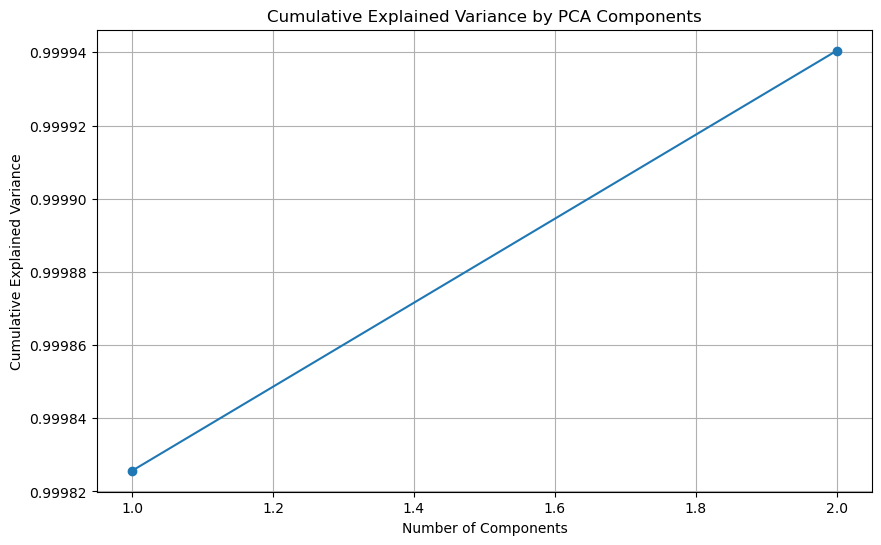

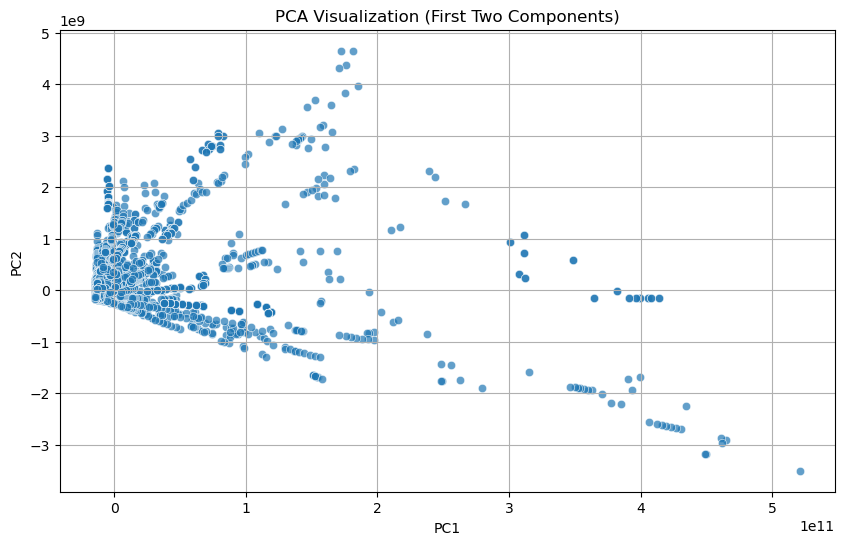

In [147]:
unsupervised_learner = UnsupervisedLearning(data)
unsupervised_learner.preprocess_data(impute_strategy='median', normalize=False, scaler_type='standard')
# Apply PCA
unsupervised_learner.apply_pca(n_components=2)
unsupervised_learner.visualize_pca()

## PCA

PCA is a linear technique that aims to maximize the variance of the data across the principal components. It does so by finding the directions in which the data varies the most and projecting the data onto these directions. While PCA effectively captures global structure and preserves variance in the data, it is not necessarily the best at preserving local relationships or non-linear structures in the data. For example, if the data lies on a non-linear manifold (e.g., a circle or spiral), PCA may not be able to capture this structure well. However, PCA is computationally efficient, interpretable, and works well when the data is linearly separable or when the goal is to reduce dimensionality while retaining as much variance as possible.

•	First Plot: The first two principal components capture 99.994% of the variance in the dataset, indicating that these components effectively represent the majority of the data’s variation. This suggests that the dataset’s structure is well captured in these two dimensions.

•	Second Plot: This plot visualizes the higher-dimensional data in a 2D space. It reveals that many of the data points are similar, but a significant portion of the dataset is spread across the first two principal components. This distribution suggests the potential for clustering within the data, as there may be groups of points that are more tightly packed together.

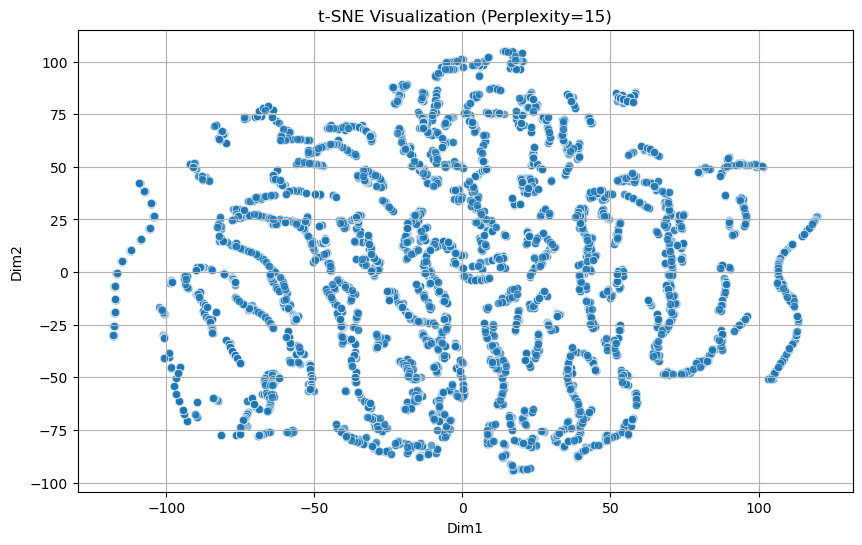

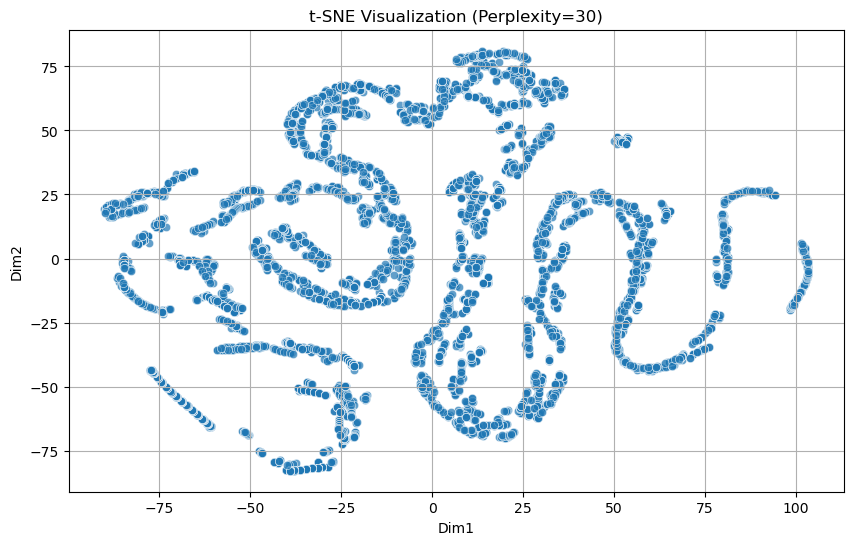

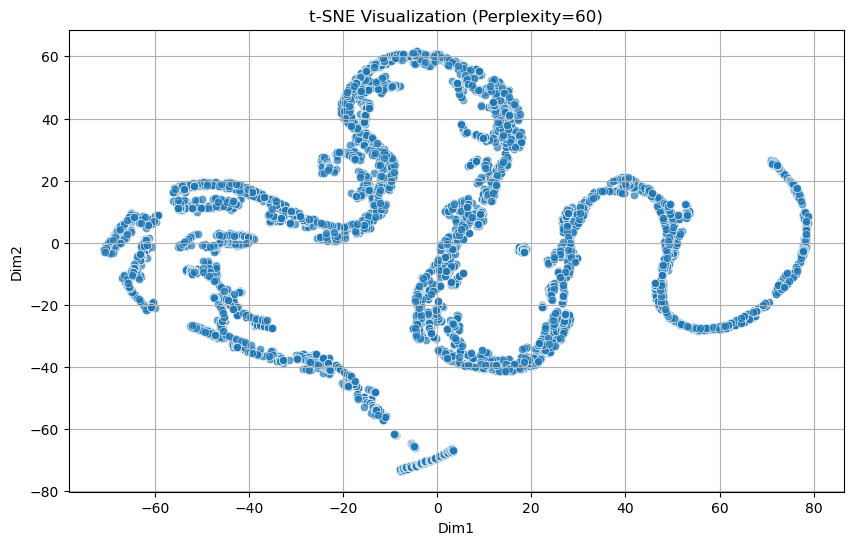

In [178]:
unsupervised_learner.apply_tsne(perplexity=15)
unsupervised_learner.apply_tsne(perplexity=30)
unsupervised_learner.apply_tsne(perplexity=60)

## t-SNE

t-SNE is a non-linear technique designed specifically to preserve local structure by minimizing the divergence between probability distributions over pairwise similarities in the high-dimensional and low-dimensional spaces. It is particularly effective for visualizing data that has a complex, non-linear structure, as it tends to group similar data points together in the low-dimensional space. However, t-SNE has some limitations, such as its computational complexity, sensitivity to hyperparameters (like perplexity), and tendency to distort global structure in favor of local relationships. This makes t-SNE less suitable for tasks where preserving the global relationships between clusters or outliers is important.

The following three plots demonstrate the effect of varying the perplexity parameter on t-SNE dimensionality reduction:

1.	Perplexity = 15: At this setting, the t-SNE output shows more spread-out data points, with clusters being less discernible. The reduced dimensionality does not reveal clear groupings within the data.

2.	Perplexity = 30: With a perplexity of 30, the t-SNE output is less spread out compared to the previous plot, but still does not reveal any separable clusters. The data points appear more concentrated, yet distinct groupings are still not visible.

3.	Perplexity = 60: At a higher perplexity value, the t-SNE output becomes even more compressed, with the data points appearing inseparable. The points are tightly packed, making it challenging to identify meaningful clusters in the reduced dimensional space.

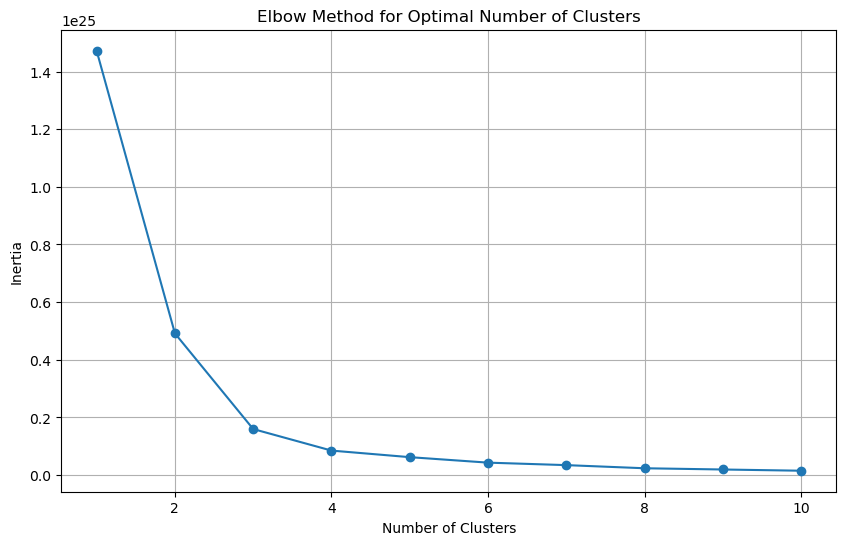

K-Means Silhouette Score: 0.8908


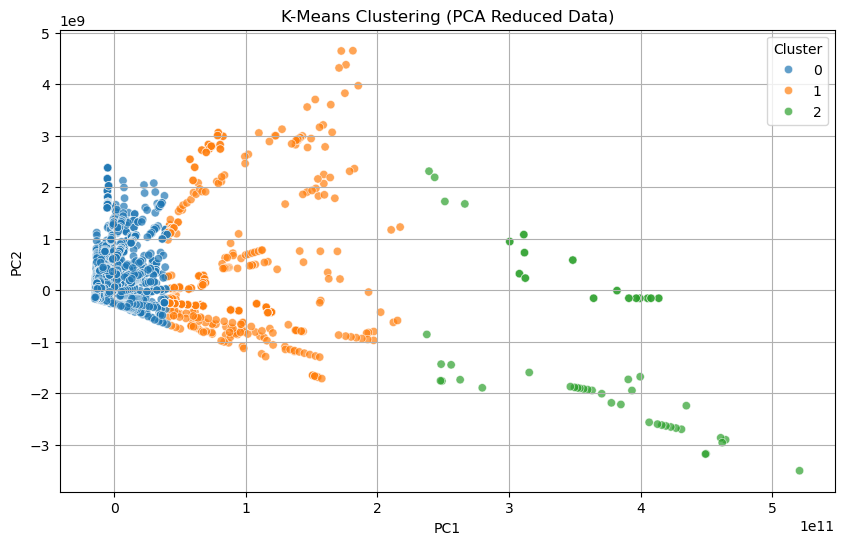

In [179]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

def elbow_method_kmeans(data, max_clusters=10):
    inertia = []
    for n_clusters in range(1, max_clusters + 1):
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        kmeans.fit(data)
        inertia.append(kmeans.inertia_)
    
    # Plot inertia vs. number of clusters
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, max_clusters + 1), inertia, marker='o')
    plt.title('Elbow Method for Optimal Number of Clusters')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia')
    plt.grid(True)
    plt.show()

# Example usage:
elbow_method_kmeans(unsupervised_learner.data)

unsupervised_learner.kmeans_clustering(n_clusters=3)

## K-Means

K-Means clustering is one of the most widely used unsupervised learning algorithms for partitioning data into distinct groups. The algorithm works by initializing a set of K centroids and iteratively refining them by assigning each data point to the nearest centroid. After assigning points to centroids, the centroids are updated to be the mean of the points in each cluster. This process repeats until convergence, where the centroids no longer change significantly. The K-Means algorithm is computationally efficient and performs well when clusters are spherical and relatively well-separated.

In our analysis, K-Means was applied to the PCA-reduced data, where the elbow method indicated that 3 clusters was the optimal choice. This choice was confirmed by the high silhouette score of 0.8908, which indicates that the clusters were well-separated and cohesive. Visualizations of the clusters showed clear groupings of data points, although some points were located between clusters, suggesting that the clusters could be further refined. The K-Means algorithm is sensitive to the initial placement of centroids, which can affect the final clusters. This limitation can be mitigated by running the algorithm multiple times with different initializations (using techniques like K-Means++ to improve the initialization process).

Despite its strengths, K-Means has limitations. It assumes that clusters are spherical and equally sized, which may not be true for all datasets. Additionally, it requires specifying the number of clusters (K) in advance, which can be challenging when the optimal number is not obvious. In this case, the elbow method and silhouette scores helped determine the best K, but this is not always straightforward in other scenarios. K-Means also struggles with outliers, as they can disproportionately influence the position of centroids. However, when the data is well-suited to K-Means, as seen in our analysis, it provides a powerful and efficient clustering method.


DBSCAN Silhouette Score: 0.5664975908757899


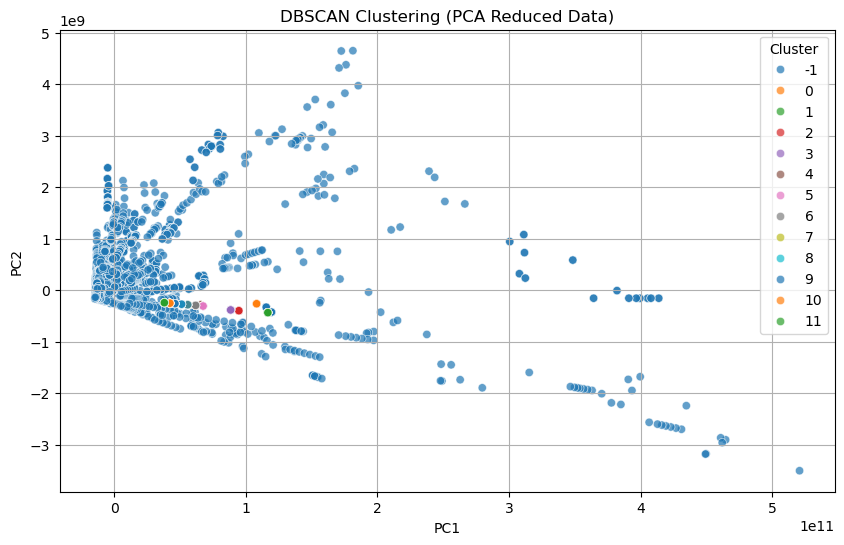

In [171]:
#from sklearn.cluster import DBSCAN
#from sklearn.metrics import silhouette_score
#import numpy as np

# def dbscan_grid_search(data, eps_range, min_samples_range):
#     best_score = -1
#     best_params = {'eps': None, 'min_samples': None}
    
#     for eps in eps_range:
#         for min_samples in min_samples_range:
#             # Apply DBSCAN
#             dbscan = DBSCAN(eps=eps, min_samples=min_samples)
#             labels = dbscan.fit_predict(data)
            
#             # DBSCAN labels: -1 represents noise, so we need at least 2 clusters to compute silhouette score
#             if len(set(labels)) > 1:
#                 score = silhouette_score(data, labels)
#                 print(f"eps: {eps}, min_samples: {min_samples}, Silhouette Score: {score:.4f}")
#                 if score > best_score:
#                     best_score = score
#                     best_params = {'eps': eps, 'min_samples': min_samples}
    
#     print(f"Best Parameters: {best_params}, Best Silhouette Score: {best_score:.4f}")
#     return best_params, best_score

# # Example usage:
# eps_range = np.linspace(0.1, 1.0, 10)  # Modify the range as needed
# min_samples_range = range(3, 10)  # Modify the range as needed
# best_params, best_score = dbscan_grid_search(unsupervised_learner.data, eps_range, min_samples_range)

#Best Parameters: {'eps': 0.1, 'min_samples': 5}, Best Silhouette Score: 0.5665

unsupervised_learner.dbscan_clustering(eps=0.1, min_samples=5)


## DBSCAN

DBSCAN is a density-based clustering algorithm that groups points that are closely packed together, marking as noise points that lie in low-density regions. Unlike K-Means, DBSCAN does not require the user to specify the number of clusters in advance. Instead, it relies on two key parameters: epsilon (eps), which defines the maximum distance between two points for them to be considered neighbors, and min_samples, which specifies the minimum number of neighbors required to form a dense region. DBSCAN’s ability to detect noise points makes it especially useful in real-world datasets that contain outliers or irregular cluster shapes.

In our experiment, DBSCAN was applied with a grid search to find the optimal parameters. The best combination was found to be eps = 0.1 and min_samples = 5. However, the algorithm resulted in a silhouette score of 0.5665, which indicates moderate cluster cohesion and separation. Additionally, many points were labeled as noise (indicated by a label of -1), meaning they did not belong to any cluster. This suggests that DBSCAN struggled to find meaningful clusters in this dataset, possibly due to the relatively uniform distribution of points or the choice of parameters.

One of DBSCAN’s main strengths is its ability to detect arbitrarily shaped clusters and identify outliers as noise, which is useful for datasets with complex structures. However, DBSCAN is highly sensitive to the choice of parameters, especially eps. If eps is too small, the algorithm may label too many points as noise, while if eps is too large, it may merge distinct clusters. Additionally, DBSCAN can struggle when clusters have varying densities, as it uses the same density criteria for all clusters. In our analysis, the inability to form meaningful clusters and the high number of noise points suggest that DBSCAN is not the best choice for this dataset.

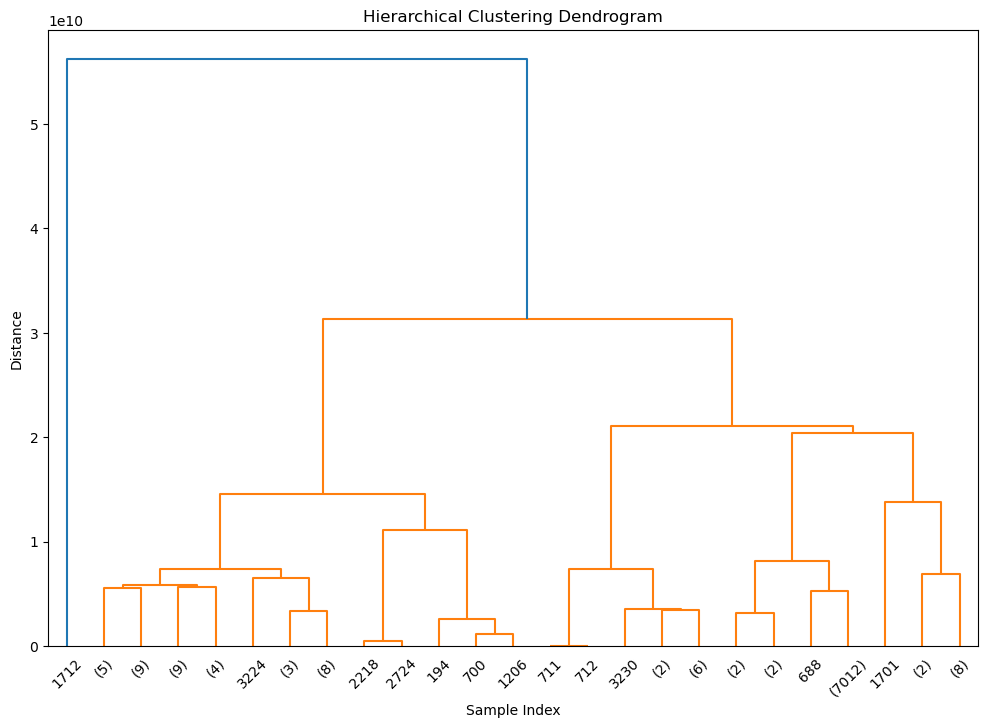

Hierarchical Clustering Silhouette Score: 0.4168


In [177]:
# from sklearn.metrics import silhouette_score
# from sklearn.cluster import AgglomerativeClustering
# import numpy as np

# def hierarchical_grid_search(data, method_range, distance_threshold_range):
#     best_score = -1
#     best_params = {'method': None, 'distance_threshold': None}
    
#     for method in method_range:
#         for distance_threshold in distance_threshold_range:
#             # Apply Agglomerative Clustering
#             hierarchical = AgglomerativeClustering(linkage=method, distance_threshold=distance_threshold, n_clusters=None)
#             labels = hierarchical.fit_predict(data)
            
#             # Get number of unique clusters
#             unique_labels = set(labels)
#             num_clusters = len(unique_labels) - (1 if -1 in unique_labels else 0)  # Exclude noise (-1) if present

#             # Check if the number of clusters is valid for silhouette score (between 2 and n_samples-1)
#             if num_clusters >= 2 and num_clusters < len(data):  # Ensure at least two clusters
#                 try:
#                     score = silhouette_score(data, labels)
#                     print(f"method: {method}, distance_threshold: {distance_threshold}, Silhouette Score: {score:.4f}")
                    
#                     if score > best_score:
#                         best_score = score
#                         best_params = {'method': method, 'distance_threshold': distance_threshold}
#                 except ValueError:
#                     print(f"Error calculating silhouette score for method: {method}, distance_threshold: {distance_threshold}")
#             else:
#                 print(f"Skipping method: {method}, distance_threshold: {distance_threshold} due to invalid number of clusters.")
    
#     print(f"Best Parameters: {best_params}, Best Silhouette Score: {best_score:.4f}")
#     return best_params, best_score

# # Example usage:
# method_range = ['ward', 'complete', 'average', 'single']  # Different linkage methods
# distance_threshold_range = np.linspace(2, 10000, 10)  # Modify the range as needed

# best_params, best_score = hierarchical_grid_search(unsupervised_learner.data, method_range, distance_threshold_range)
#Best Parameters: {'method': 'single', 'distance_threshold': 10000.0}, Best Silhouette Score: 0.4168

unsupervised_learner.hierarchical_clustering("single",distance_threshold = 10000)

## Hierarchical Clustering

Hierarchical clustering is a method of cluster analysis that builds a hierarchy of clusters. It can be performed using either an agglomerative approach (bottom-up) or a divisive approach (top-down). In agglomerative hierarchical clustering, each data point starts as its own cluster, and pairs of clusters are merged at each step based on their similarity, typically measured using a distance metric (e.g., Euclidean distance). The process continues until all points are merged into a single cluster or until a predefined stopping criterion is met. The result of hierarchical clustering is typically represented in a dendrogram, which shows the hierarchical relationships between the clusters.

In our analysis, we applied agglomerative hierarchical clustering with various methods (single, complete, average) and distance thresholds. The single linkage method, which merges clusters based on the closest pair of points, resulted in the best silhouette score of 0.4168. The clusters formed were relatively coherent, but the silhouette score indicates that the clustering was less distinct compared to K-Means. Hierarchical clustering’s main advantage is that it does not require the number of clusters to be specified in advance, as the tree-like structure allows for flexible cluster cutting at any level. However, the resulting clusters may not always be as well-separated as those produced by K-Means, especially when the data has more complex structures.

While hierarchical clustering provides useful insights into the relationships between data points, it can become computationally expensive with large datasets due to its pairwise distance calculations. The method also tends to be sensitive to the choice of distance metric and linkage method. In this case, the single method and distance threshold of 10000.0 gave the best results, but the moderate silhouette score suggests that the clusters were not as well-defined as with K-Means. This makes hierarchical clustering more suitable for exploratory data analysis or when hierarchical relationships are important, rather than when distinct and well-separated clusters are required for practical applications.

## Results

In this section, we present and analyze the outcomes from the different clustering methods applied to the dataset. We evaluated the effectiveness of K-Means, DBSCAN, and Hierarchical Clustering, highlighting the strengths and weaknesses of each approach.

K-Means Clustering:

	•	We applied K-Means clustering with an optimal number of clusters identified through the elbow method. The silhouette score of 0.8908 indicates strong cluster cohesion and separation. The clusters were well-defined when visualized on the PCA-reduced data. However, there were some ambiguous points between clusters 0 and 1, suggesting that further refinement could improve the classification.

DBSCAN Clustering:

	•	DBSCAN, with the optimal parameters (eps: 0.1, min_samples: 5), resulted in a silhouette score of 0.5665. Several points were labeled as noise, indicating that DBSCAN struggled to form meaningful clusters. This suggests that DBSCAN may not be suitable for this dataset, as it does not capture the inherent structure as well as K-Means.

Hierarchical Clustering:

	•	Hierarchical clustering with the single method and a distance_threshold of 10000.0 achieved a silhouette score of 0.4168. This result suggests that the method produced somewhat coherent clusters, but with less clarity than K-Means. The dendrogram helped visualize the relationships between samples, but the moderate silhouette score indicates the clusters were not highly distinct.

Cluster Visualization and Comparison:

	•	Visualizations were used to display the results of each clustering method, highlighting the separation of clusters. PCA and t-SNE reduction techniques were employed to project the data into 2D, making it easier to visualize the clustering outcomes.

	•	K-Means clusters appeared well-separated, though there were some overlapping points.

	•	DBSCAN showed scattered clusters with many noise points.

	•	Hierarchical clustering, while offering a reasonable structure, did not achieve the same level of separation as K-Means.

Cluster-Label Comparison:

	•	When comparing the clustering results with the known labels in the dataset, we observed that the K-Means clustering provided the best match in terms of consistency. DBSCAN and Hierarchical clustering, however, did not align as well, especially with DBSCAN’s high number of noise points.

## Conclusion

In this analysis, we applied three clustering techniques to understand the underlying structure of the dataset: K-Means, DBSCAN, and Hierarchical Clustering.

Key Findings:

	•	K-Means clustering emerged as the most effective method, yielding clear clusters with strong cohesion and separation, as reflected in its high silhouette score of 0.8908.

	•	DBSCAN, while offering the advantage of identifying noise points, did not perform well on this dataset, with a lower silhouette score (0.5665) and many points classified as noise.

	•	Hierarchical clustering, despite providing some useful insights into the data structure, resulted in a moderate silhouette score (0.4168), indicating that its performance was not as robust as K-Means.

Practical Implications:

	•	K-Means is the most suitable clustering technique for this dataset, offering clear, actionable clusters that can inform further analysis or decision-making processes.

	•	DBSCAN’s inability to form meaningful clusters suggests that it may not be the right choice for datasets with complex, but dense structures.
    
	•	Hierarchical clustering provides valuable hierarchical relationships but may not be the best method when distinct cluster separation is needed for practical applications.

These findings suggest that K-Means could be used for segmenting this type of data in real-world applications such as food waste analysis, where identifying distinct clusters of waste categories or nutritional groups is important for developing targeted sustainability measures.